**Wikipedia -api**

In [2]:
!pip install wikipedia-api  # Install wikipedia-api using pip
!pip install faiss-cpu # Install the faiss library


  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.7.1-py3-none-any.whl size=14346 sha256=445585cfb682204d3b541a45abcbb9aa3d9c1c4ccd335c1f8f27160263c427ed
  Stored in directory: /root/.cache/pip/wheels/4c/96/18/b9201cc3e8b47b02b510460210cfd832ccf10c0c4dd0522962
Successfully built wikipedia-api
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 83.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
from transformers import pipeline
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
import wikipediaapi

# Define a descriptive user agent string
user_agent = "MyWikipediaApp/1.0 (MyEmail@example.com)"

# Step 1: Initialize Wikipedia API and Fetch Content
def fetch_wikipedia_content(page_name, lang='en'):
    # Pass the user_agent argument when creating the Wikipedia object
    wiki = wikipediaapi.Wikipedia(user_agent=user_agent, language=lang) # Added user_agent here
    page = wiki.page(page_name)
    if not page.exists():
        print(f"Page '{page_name}' does not exist.")
        return None
    return page.text



# Chunk text into smaller segments
def chunk_text(text, max_chunk_size=500):
    """
    Splits large text into smaller chunks of the specified size.
    """
    words = text.split()
    chunks = []
    for i in range(0, len(words), max_chunk_size):
        chunks.append(" ".join(words[i:i + max_chunk_size]))
    return chunks

# Build FAISS index
def build_faiss_index(chunks):
    """
    Builds a FAISS index from the text chunks.
    """
    embeddings = embedding_model.encode(chunks)
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(np.array(embeddings, dtype=np.float32))
    return index, embeddings

# Query FAISS index
def query_faiss_index(query, index, chunks, top_k=5):
    """
    Queries the FAISS index to retrieve top-matching text chunks.
    """
    query_embedding = embedding_model.encode([query])
    _, indices = index.search(np.array(query_embedding, dtype=np.float32), top_k)
    results = [chunks[i] for i in indices[0]]
    return results

# Summarize results
def summarize_results(results):
    """
    Summarizes the results retrieved from the FAISS index.
    """
    combined_text = " ".join(results)

    # Explicitly set max_length for truncation before passing to summarizer
    max_input_length = summarizer.model.config.max_position_embeddings
    truncated_text = combined_text[:max_input_length]

    # Enforce truncation and set max_length for summarization
    summary = summarizer(truncated_text, max_length=130, min_length=30, do_sample=False, truncation=True)
    return summary[0]['summary_text']



# Save to CSV
def save_to_csv(filename, data, columns):
    """
    Saves data to a CSV file.
    """
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(filename, index=False)

# Main Function
if __name__ == "__main__":
    # Initialize summarization and embedding models
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
    embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

    # Define topics
    topics = ["Thyroid", "Cells", "Brain", "Kidney", "Liver",
              "Heart", "Lungs", "Diabetes", "Cancer", "Obesity"]

    # Step 1: Fetch and preprocess content
    full_content = []
    summarized_content = []
    all_chunks = []
    for topic in topics:
        print(f"Fetching content for topic: {topic}")
        content = fetch_wikipedia_content(topic)
        if content:
            full_content.append({"Topic": topic, "Content": content})
            chunks = chunk_text(content)
            all_chunks.extend(chunks)
            summary = summarize_results([content])
            summarized_content.append({"Topic": topic, "Summary": summary})

    # Step 2: Build FAISS index
    print("Building FAISS index...")
    index, embeddings = build_faiss_index(all_chunks)

    # Step 3: Query and summarize
    user_query = input("Enter your query: ")
    top_results = query_faiss_index(user_query, index, all_chunks)
    summary = summarize_results(top_results)

    print("\nSummary:\n", summary)

    # Prepare query results for CSV
    query_results = [{"Query": user_query, "Result": result} for result in top_results]
    query_summary = [{"Query": user_query, "Summary": summary}]

    # Save to CSV
    print("Saving data to CSV files...")
    save_to_csv("full_content.csv", full_content, ["Topic", "Content"])
    save_to_csv("query_results.csv", query_results, ["Query", "Result"])
    save_to_csv("query_summary.csv", query_summary, ["Query", "Summary"])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Fetching content for topic: Thyroid


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Fetching content for topic: Cells
Fetching content for topic: Brain
Fetching content for topic: Kidney
Fetching content for topic: Liver
Fetching content for topic: Heart
Fetching content for topic: Lungs
Fetching content for topic: Diabetes
Fetching content for topic: Cancer
Fetching content for topic: Obesity
Building FAISS index...
Enter your query: What are the reason for Obesity

Summary:
 Obesity is a medical condition, sometimes considered a disease, in which excess body fat has accumulated to such an extent that it can potentially have negative effects on health. People are classified as obese when their body mass index (BMI) is over 30 kg/m2.
Saving data to CSV files...



Processing Topic: What are the reason for Obesity
Visualizing graph for topic: What are the reason for Obesity


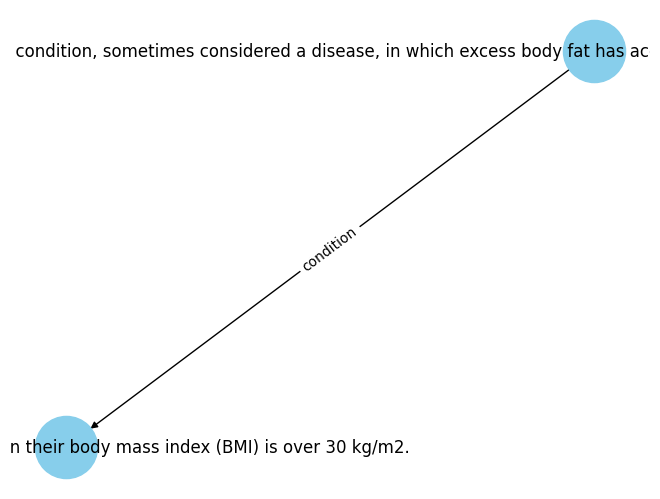

In [4]:
import pandas as pd
import spacy
import networkx as nx
import matplotlib.pyplot as plt

# Load spaCy model for dependency parsing
nlp = spacy.load("en_core_web_sm")

# Define a simple relation classifier
def classify_relation(text):
    """
    Classify relationships based on keywords in the text.
    """
    if "because" in text or "due to" in text:
        return "causality"
    elif "if" in text or "then" in text:
        return "condition"
    elif "after" in text or "before" in text:
        return "sequence"
    elif "more than" in text or "less than" in text:
        return "comparison"
    else:
        return "unknown"

# Function to extract text segments
def extract_text_segments(text):
    """
    Extracts meaningful text segments using spaCy dependency parsing.
    """
    doc = nlp(text)
    segments = [sent.text.strip() for sent in doc.sents]
    return segments

# Function to create a graph
def create_text_graph(segments, relationships):
    """
    Create a graph where nodes are segments and edges are relationships.
    """
    G = nx.DiGraph()  # Directed graph for logical flow

    # Add nodes
    for i, segment in enumerate(segments):
        G.add_node(i, text=segment)

    # Add edges with relationship labels
    for i in range(len(relationships)):
        G.add_edge(i, i + 1, relation=relationships[i])

    return G

# Function to visualize the graph
def visualize_graph(graph):
    """
    Visualizes the graph using matplotlib and networkx.
    """
    pos = nx.spring_layout(graph)  # Layout for nodes
    labels = nx.get_node_attributes(graph, 'text')
    edge_labels = nx.get_edge_attributes(graph, 'relation')

    # Draw nodes and labels
    nx.draw(graph, pos, with_labels=True, labels=labels, node_size=2000, node_color="skyblue")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    plt.show()

# Main function to process CSV
def process_csv_and_analyze(file_path):
    # Load CSV file
    df = pd.read_csv("/content/query_summary.csv") #file path

    # Check for 'Summary' or any text column
    if 'Summary' not in df.columns:
        raise ValueError("CSV must contain a 'Summary' column with text data.")

    for _, row in df.iterrows():
        topic = row.get("Query", "Unknown Topic")
        text = row["Summary"]
        print(f"\nProcessing Topic: {topic}")

        # Step 1: Extract segments
        segments = extract_text_segments(text)

        # Step 2: Classify relationships
        relationships = [
            classify_relation(segments[i] + " " + segments[i + 1])
            for i in range(len(segments) - 1)
        ]

        # Step 3: Create graph
        graph = create_text_graph(segments, relationships)

        # Step 4: Visualize graph
        print(f"Visualizing graph for topic: {topic}")
        visualize_graph(graph)

# File path to the CSV (replace with your file)
csv_file_path = "/content/query_summary.csv"

# Call the main function
process_csv_and_analyze(csv_file_path)


In [5]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cu116.html

Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html
  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Preparing metadata (setup.py) ... done
  Using cached torch_sparse-0.6.18.tar.gz (209 kB)
  Preparing metadata (setup.py) ... done
  Using cached torch_cluster-1.6.3.tar.gz (54 kB)
  Preparing metadata (setup.py) ... done
  Using cached https://data.pyg.org/whl/torch-1.13.0%2Bcu116/torch_spline_conv-1.2.2%2Bpt113cu116-cp310-cp310-linux_x86_64.whl (868 kB)
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=3671568 sha256=55efe5e19a62fba59b14d47a5d176d13e146408e36815c75f3e9c27342c8ce51
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=2794568 